In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

Saving 2091402.csv to 2091402.csv


In [21]:
counts = pd.read_csv('Fremont_Bridge_Bicycle_Counter.csv', index_col = 'Date', parse_dates = True)
weather = pd.read_csv('2091402.csv', index_col = 'DATE', parse_dates = True)

daily = counts.resample('d', how = 'sum')
daily['Total'] = daily.sum(axis = 1)
daily = daily[['Total']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  after removing the cwd from sys.path.


In [0]:
days = ['Mon', 'Tue', 'Wed', 'Thu','Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [0]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012','2016')
daily = daily.join(pd.Series(1,index = holidays, name = 'holiday'))
daily['holiday'].fillna(0, inplace = True)

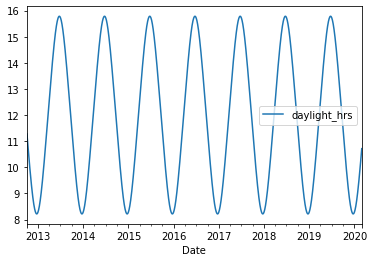

In [24]:
def hours_of_daylight(date, axis = 23.44, latitude = 47.61):
    days = (date - pd.datetime(2000,12,21)).days
    m = (1. - np.tan(np.radians(latitude))
        * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))

    return 24. * np.degrees(np.arccos(1 - np.clip(m,0,2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()

In [0]:
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

#daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])


In [46]:
daily['annual'] = (daily.index - daily.index[0]).days /365.
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,annual
Date,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.010959


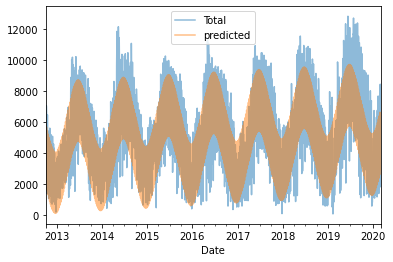

In [58]:
from sklearn.linear_model import LinearRegression

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept = False)
model.fit(X,y)
daily['predicted'] = model.predict(X)
daily[['Total','predicted']].plot(alpha = 0.5)

In [59]:
params = pd.Series(model.coef_, index = X.columns)
params

Mon            -1284.735518
Tue             -936.070052
Wed             -993.747501
Thu            -1311.112350
Fri            -1961.757489
Sat            -4762.888993
Sun            -4893.978269
holiday        -1904.209535
daylight_hrs     605.756106
annual           165.904042
dtype: float64

In [60]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X,y)).coef_
              for i in range(1000)],0)
print(pd.DataFrame({'effect' : params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon          -1285.0  145.0
Tue           -936.0  143.0
Wed           -994.0  141.0
Thu          -1311.0  143.0
Fri          -1962.0  141.0
Sat          -4763.0  133.0
Sun          -4894.0  136.0
holiday      -1904.0  329.0
daylight_hrs   606.0   10.0
annual         166.0   14.0
